# 3a. Autocorrecting Mispelt Taxon Names with Autoencoders
Given a list of taxon names, can we build an autocorrect model to autonomously fix erroneous records?

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import string
import h5py
from keras.models import Model
from keras.preprocessing import sequence
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping

## Exploring the dataset
We'll use the same dataset as last time; a publically available list of UK exports from 1975 - 2016. We'll only need the taxon names so we'll restrict our import to the taxon column.

In [27]:
dataframe = pd.read_csv("data/goal_2_data.csv", skipinitialspace=True, usecols=["Taxon"])

dataframe

,Taxon
0,Equus przewalskii
1,Panthera onca
2,Varanus flavescens
3,Varanus griseus
4,Branta ruficollis
5,Leopardus pardalis
6,Leopardus wiedii
7,Diceros bicornis
8,Asarcornis scutulata
9,Branta sandvicensis


In [28]:
name_distribution = dataframe["Taxon"].value_counts()
name_distribution

Loxodonta africana              3606
Python reticulatus              1523
Alligator mississippiensis      1297
Macaca fascicularis             1279
Varanus salvator                 972
Elephas maximus                  952
Cheloniidae spp.                 866
Varanus niloticus                744
Elephantidae spp.                716
Crocodylus niloticus             685
Psittacus erithacus              632
Crocodylus porosus               560
Caiman crocodilus crocodilus     524
Python bivittatus                501
Ptyas mucosus                    473
Chlorocebus aethiops             457
Falco peregrinus                 403
Eretmochelys imbricata           393
Dalbergia nigra                  354
Vicugna vicugna                  337
Panthera pardus                  325
Callithrix jacchus               323
Odobenus rosmarus                299
Falco rusticolus                 296
Panthera tigris                  283
Physeter macrocephalus           255
Hirudo medicinalis               249
M

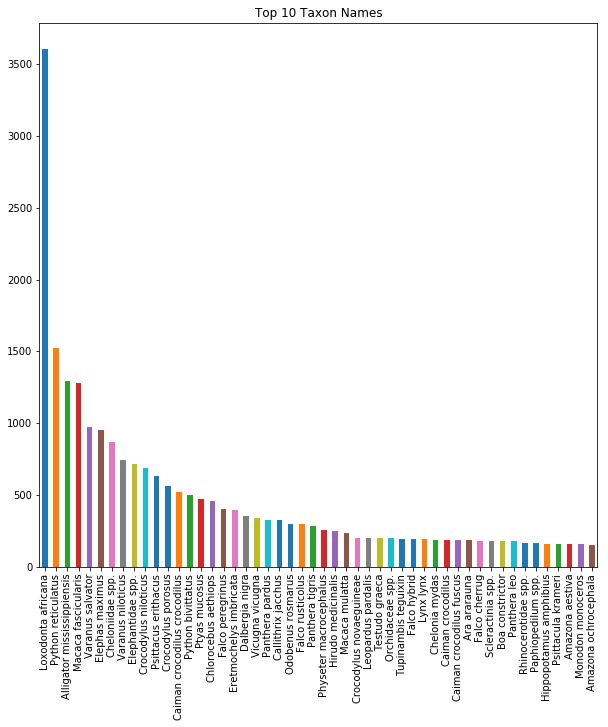

In [29]:
name_distribution.head(50).plot.bar(figsize=(10, 10), title="Top 10 Taxon Names")

Obviously we can't use this for our training set as our model would disproportionatly learn to correct everything to "Loxodonta africana". We'll have to create a dataset of unique names...

In [30]:
names = dataframe["Taxon"].unique()

print("Total taxon names: ", len(names))
names

Total taxon names:  3422


array(['Equus przewalskii', 'Panthera onca', 'Varanus flavescens', ...,
       'Phaethornis longirostris', 'Mesoplodon stejnegeri',
       'Martes flavigula'], dtype=object)

Now we have a list of 3422 names that we can train our model on, but we'll need to generate some fake spelling mistakes first, so let's write a function to do that...

In [31]:
def spelling_mistake_generator(name):
    n = random.randint(0,4)
    if n == 0:
        return remove_letter(name)
    elif n == 1:
        return add_letter(name)
    elif n == 2:
        return swap_letters(name)
    elif n == 3:
        name = remove_letter(name)
        return add_letter(name)
    elif n == 4:
        return lowercase(name)

def remove_letter(name):
    random_slice = random.randint(0, len(name))
    generated_name = name[:random_slice] + name[(random_slice + 1):]
    return generated_name

def add_letter(name):
    random_slice = random.randint(0, len(name))
    random_letter = random.choice(string.ascii_letters)
    generated_name = name[:random_slice] + random_letter + name[(random_slice + 1):]
    return generated_name

def swap_letters(name):
    random_slice = random.randint(0, len(name) - 2)
    generated_name = name[:random_slice] + reversed_string(name[random_slice:random_slice + 2]) + name[random_slice + 2:]
    return generated_name
    
def reversed_string(a_string):
    return a_string[::-1]

def lowercase(name):
    return name.lower()

print(spelling_mistake_generator("Loxodonta africana"))

Loodonta afriTana


In [32]:
for i in range(10):
    print(spelling_mistake_generator("Loxodonta africana"))

Loxodonta faricana
Loxodonta africanI
Loxodonta aficana
loxodonta africana
LoxodZnta africana
Loxodonta africaan
Loxodonta aDricna
Loxodonta afrciana
Loxodona africaDa
Boxodonta africaa


## Generating our Rosetta Stone

We'll use our new spelling mistake generator to generate a new dataset where we have the erroneous data in one column, and the correct data next to it. Since we get a different mistake each time we run the generator, we'll create 100 examples of each term...

In [33]:
repeated_names = np.repeat(names, 100)
spelling_errors = [spelling_mistake_generator(s) for s in repeated_names]

corpus = np.column_stack((spelling_errors, repeated_names))

corpus = pd.DataFrame(corpus, columns=["Input", "Target"])
corpus

,Input,Target
0,Equus pzewalskUi,Equus przewalskii
1,EKuus przewalskii,Equus przewalskii
2,Fquus przewalskii,Equus przewalskii
3,Equusp rzewalskii,Equus przewalskii
4,equus przewalskii,Equus przewalskii
5,EqSus przewalskii,Equus przewalskii
6,Equs przewalskii,Equus przewalskii
7,Equus pszewalskii,Equus przewalskii
8,Equus pSzewalkii,Equus przewalskii
9,Equus pzrewalskii,Equus przewalskii


We've ended up with 342200 records of names with minor typos and formatting mistakes. (You can change the number of repetitions from 100 to 1000 if you need more data, but I've left this as 100 to save time. 1000 and upwards takes a little while to generate)

## Vectorise our data for learning

We'll need to encode our data from letters to number for our model to be able to deal with it. We'll take our table, and create two lists, one of all the characters in our input dataset, and one of all the characters in our target dataset. We can use these later on to one hot encode our characters to vectors before we feed them to our model. We'll also add a start and end character to our target data as this will be useful for our model to understand when to start and stop generating...

In [34]:
input_texts = []
target_texts = []

start_character = '\t'
end_character = '\n'

input_characters = set()
target_characters = set()

In [35]:
# Takes in the input and target texts and adds their characters to the list of input and target characters

def build_character_lists(input_text, target_text):
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [36]:
for index, row in corpus.iterrows():
    input_text = row["Input"]
    target_text = row["Target"]
    target_text = start_character + target_text + end_character
    build_character_lists(input_text, target_text)
    input_texts.append(input_text)
    target_texts.append(target_text)

In [37]:
input_characters   = sorted(list(input_characters))
target_characters  = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

target_characters

Number of samples: 342200
Number of unique input tokens: 55
Number of unique output tokens: 56
Max sequence length for inputs: 37
Max sequence length for outputs: 38


['\t',
 '\n',
 ' ',
 '-',
 '.',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

We'll create two dictionaries to help us get from our characters to numbers and back for both our input and target dataset

In [38]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

print(input_token_index)
print(target_token_index)

{' ': 0, '-': 1, '.': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, 'a': 29, 'b': 30, 'c': 31, 'd': 32, 'e': 33, 'f': 34, 'g': 35, 'h': 36, 'i': 37, 'j': 38, 'k': 39, 'l': 40, 'm': 41, 'n': 42, 'o': 43, 'p': 44, 'q': 45, 'r': 46, 's': 47, 't': 48, 'u': 49, 'v': 50, 'w': 51, 'x': 52, 'y': 53, 'z': 54}
{'\t': 0, '\n': 1, ' ': 2, '-': 3, '.': 4, 'A': 5, 'B': 6, 'C': 7, 'D': 8, 'E': 9, 'F': 10, 'G': 11, 'H': 12, 'I': 13, 'J': 14, 'K': 15, 'L': 16, 'M': 17, 'N': 18, 'O': 19, 'P': 20, 'Q': 21, 'R': 22, 'S': 23, 'T': 24, 'U': 25, 'V': 26, 'W': 27, 'X': 28, 'Z': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [39]:
# encoder_input_data is a 3D array of shape (num_pairs, max input seq length, num input characters)
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

# decoder_input_data is a 3D array of shape (num_pairs, max target seq length, num target characters)
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

# decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

## Building our model

In [40]:
# i = training examples
# t = time step
# c = set the position representing the character to 1 (one hot encoded character)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [41]:
latent_dim = 256

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [42]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [43]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [44]:
batch_size = 64  # Batch size for training.
epochs = 100 # Number of epochs to train for.
training_mode = True # Change this to true to train the model

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, verbose=1, mode='auto')

# Run training
if training_mode == False:
    model.load_weights("s2s.h5")
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
else:
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size,
              epochs=epochs, 
              callbacks=[early_stop],
              validation_split=0.2)
    model.save('s2s.h5')

Train on 273760 samples, validate on 68440 samples
Epoch 1/1
273760/273760 [==============================] - 709s 3ms/step - loss: 0.5920 - val_loss: 1.1982


/usr/local/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [45]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
(i, char) for char, i in target_token_index.items())

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [47]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Equus pzewalskUi
Decoded sentence: Echinopsis chiloensis

-
Input sentence: EKuus przewalskii
Decoded sentence: Eulemur colona

-
Input sentence: Fquus przewalskii
Decoded sentence: Funcia spp.

-
Input sentence: Equusp rzewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: equus przewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: EqSus przewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: Equs przewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: Equus pszewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: Equus pSzewalkii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: Equus pzrewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: lquus przewalskii
Decoded sentence: Saguinus midas

-
Input sentence: Eaus przewalskii
Decoded sentence: Euphorbia stenoclada

-
Input sentence: Equus pzzewalskii
Decoded sentence: Echinopsis chiloensis

-
Input sentence: Equus frze